In this notebook comparable models for predicting exacerbations will be benchmarked against the models developed in this thesis. The models of interest are:
* ADO: age, dyspnoea, obstruction (https://www.dovepress.com/external-validation-of-the-updated-ado-score-in-copd-patients-from-the-peer-reviewed-fulltext-article-COPD)
* BODE: bmi, obstruction, dyspnoea, exercise capacity (https://www.mdcalc.com/calc/3916/bode-index-copd-survival#evidence)
* DOSE: dyspnoea, obstruction, smoking, exacerbations (https://www.nature.com/articles/pcrj201254/tables/1)
* BCSS: breathlessness, cough, sputum scale (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5131613/)
* previous exacerbations alone (current clinical standard)
* CAT: COPD assessment test

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Preparing Data

In [6]:
exaggerate = pd.read_csv('exaggerate/data/working_sheet.csv', sep=";")

In [7]:
# prepare datasets
harvard = pd.read_csv('harvard/data/Original Data/original_data.csv', sep=";")

print(harvard.shape)
relevant_variables = ["mmrc", 'dem02','dem03', 'bclinra202c_2', 'bclinra202c_5', 'fclinra08', 'bclinra14','bclinra01','bclinra02','bclinpt22', 'sgrq02','sgrq03','sgrq04', 'login', 'bclinpt04', 'bclinpt15', 'bclinpt07', 'bclinpt34', 'bclinpt28']
# pretty print column list


harvard = harvard[relevant_variables]
print(harvard.columns.tolist())
harvard = harvard.rename(columns={"mmrc": "mmrc", "dem02": "age", "bclinra202c_2": "percent_fev1_1", "bclinra202c_5": "percent_fev1_2", "fclinra08": "exacerbation", 'bclinra14': '6MWT', 'bclinra01':'height', 'bclinra02':'weight', 'bclinpt22': 'prev_exacerbations', 'dem03': 'gender', 'bclinpt19': 'cancer', 'bclinpt04': 'hypertension', 'bclinpt15': 'diabetes', 'bclinpt07': 'heart_failure', 'bclinra01': 'height', 'bclinra02': 'weight', 'bclinpt34': 'fever',  'bclinpt08':'myocardial_infarct', 'bclinpt09':'stroke', 'bclinpt28':'dyspnoea', 'bclinpt36': 'fast_breathing'})

print(harvard.columns.tolist())

# get the baseline
# get all unique values in the login column
unique_logins = harvard['login'].unique()
# baseline dataframe has the same columns as the original dataset
baseline = []
for login in unique_logins:
    # add the first row of the selection to the baseline dataset
    baseline.append(harvard[harvard['login'] == login].iloc[0])
# turn lists into dataframes but with columns from harvard dataset
harvard = pd.DataFrame(baseline, columns=harvard.columns)
harvard = harvard.drop(columns=['login'], axis=1)
print(harvard.columns.tolist())

# make mmrc start at 0
harvard['mmrc'] = harvard['mmrc'] - 1
# get rid of all rows with exacerbation = 3
harvard = harvard[harvard['exacerbation'] != 3]
# make exacerbation start at 0
harvard['exacerbation'] = harvard['exacerbation'] - 1
# if exacerbation is 1, make it 0 and vice versa
harvard['exacerbation'] = 1 - harvard['exacerbation']
# create percent_fev1 column
harvard['percent_fev1'] = harvard['percent_fev1_1']
# if percent_fev1_1 is nan, use percent_fev1_2
harvard.loc[harvard['percent_fev1_1'].isnull(), 'percent_fev1'] = harvard['percent_fev1_2']
# if percent_fev1_2 is larger than percent_fev1_1, use percent_fev1_2 for percent_fev1
harvard.loc[harvard['percent_fev1_2'] > harvard['percent_fev1_1'], 'percent_fev1'] = harvard['percent_fev1_2']
# drop percent_fev1_1 and percent_fev1_2
harvard = harvard.drop(['percent_fev1_1', 'percent_fev1_2'], axis=1)

# drop all rows where exacerbation is nan
harvard = harvard.dropna(subset=['exacerbation'])

# turn exacerbation into integer from float
harvard['exacerbation'] = harvard['exacerbation'].astype(int)
#print nan values
print(harvard.isnull().sum())

(2796, 926)
['mmrc', 'dem02', 'dem03', 'bclinra202c_2', 'bclinra202c_5', 'fclinra08', 'bclinra14', 'bclinra01', 'bclinra02', 'bclinpt22', 'sgrq02', 'sgrq03', 'sgrq04', 'login', 'bclinpt04', 'bclinpt15', 'bclinpt07', 'bclinpt34', 'bclinpt28']
['mmrc', 'age', 'gender', 'percent_fev1_1', 'percent_fev1_2', 'exacerbation', '6MWT', 'height', 'weight', 'prev_exacerbations', 'sgrq02', 'sgrq03', 'sgrq04', 'login', 'hypertension', 'diabetes', 'heart_failure', 'fever', 'dyspnoea']
['mmrc', 'age', 'gender', 'percent_fev1_1', 'percent_fev1_2', 'exacerbation', '6MWT', 'height', 'weight', 'prev_exacerbations', 'sgrq02', 'sgrq03', 'sgrq04', 'hypertension', 'diabetes', 'heart_failure', 'fever', 'dyspnoea']
mmrc                   0
age                    0
gender                 0
exacerbation           0
6MWT                  71
height                 7
weight                 6
prev_exacerbations     0
sgrq02                 0
sgrq03                 1
sgrq04                 2
hypertension           8
d

C:\Users\Daniel\AppData\Local\Temp\ipykernel_2236\4529406.py:2: DtypeWarning: Columns (3,26,218,247,251) have mixed types. Specify dtype option on import or set low_memory=False.
  harvard = pd.read_csv('harvard/data/Original Data/original_data.csv', sep=";")


In [8]:
triage = pd.read_excel('triage/data/data.xlsx')

# dyspnoea, diabetes, cancer, bmi, age, stroke, myocardial infarct, mmrc, hypertension, heart_failure, gender, fever, fast_breathing

# exaggerate = exaggerate.rename(columns={'sex': 'gender', 'dyspnoea_mMRC': 'mmrc', 'ami':'myocardial_infarct', 'cbd':'stroke', 'dyspnoea_yesno':'dyspnoea', target:'target'})

# remove all empty rows
triage = triage.dropna(how='all')

# drop Alternate Diagnosis? (y/n), Final Triage 1 (1-4), Confidence 1 (%), Final Triage 2 (1-4), Confidence 2 (%), Highly Unrealistic Case (Y), Highly Uncertain (Y), Profile Severity (1-5)
triage = triage.drop(columns=['Unnamed: 0', 'Alternate Diagnosis? (y/n)', 'Final Triage 1 (1-4)', 'Confidence 1 (%)', 'Final Triage 2 (1-4)', 'Confidence 2 (%)', 'Highly Unrealistic Case (Y)', 'Highly Uncertain (Y)', 'Profile Severity (1-5)'], axis=1)
# reset index


triage = triage.drop(triage.columns[triage.columns.get_loc('Exacerbation (Y/N)') + 1:], axis=1)

# drop Vitals Severity (1-5)
triage = triage.drop(columns=['Vitals Severity (1-5)'], axis=1)

# convert all values where it say 'Unknown' to NaN
triage = triage.replace('Unknown', np.nan)

# turn Male into 1 and Female into 0
triage = triage.replace('Male', 1)
triage = triage.replace('Female', 0)

# convert height from Height(ft) and Height(in) to Height(cm)
triage['Height(cm)'] = triage['Height(ft)'] * 30.48 + triage['Height(in)'] * 2.54
# drop Height(ft) and Height(in)
triage = triage.drop(columns=['Height(ft)', 'Height(in)'], axis=1)

# convert weight from Weight(lbs) to Weight(kg)
triage['Weight(kg)'] = triage['Weight (lb)'] * 0.45359237
# drop Weight(lbs)
triage = triage.drop(columns=['Weight (lb)'], axis=1)

# recalculate BMI for metric system
triage['BMI'] = triage['Weight(kg)'] / (triage['Height(cm)'] / 100) ** 2

# convert temperature from Temperature(F) to Temperature(C)
triage['Current Temperature'] = (triage['Current Temperature'] - 32) * 5 / 9

risk_factors = ()
# add all unique values in columns Risk Factor 1-4 to risk_factors, make sure there are no duplicates
for i in range(1, 5):
    risk_factors += tuple(triage['Risk Factor ' + str(i)].unique())
risk_factors = tuple(set(risk_factors))
# remove NaN from risk_factors
risk_factors = tuple(filter(lambda x: x == x, risk_factors))
# create a column for each risk factor in risk_factors
for risk_factor in risk_factors:
    triage[risk_factor] = 0
# set all values in the columns to 1 if the risk factor is present
for i in range(1, 5):
    for risk_factor in risk_factors:
        triage.loc[triage['Risk Factor ' + str(i)] == risk_factor, risk_factor] = 1
# drop Risk Factor 1-4
triage = triage.drop(columns=['Risk Factor ' + str(i) for i in range(1, 5)], axis=1)

medications = ()
# split each value in 'Current Medication' at + and add the medication to the tuple if it is not already in there
for medication in triage['Current Medication']:
    # if the value is not empty
    if medication == medication:
        # split the value at + and add the medication to the tuple if it is not already in there
        for med in str(medication).split('+'):
            if med not in medications:
                medications += (med,)

# create a column for each medication in medications
for medication in medications:
    triage[medication] = 0
# set all values in the columns to 1 if the medication is present
for medication in medications:
    triage.loc[triage['Current Medication'].str.contains(medication, na=False), medication] = 1
# drop Current Medication
triage = triage.drop(columns=['Current Medication'], axis=1)

# turn Baseline Dyspnea (MMRC) into the number that the value contains
triage['Baseline Dyspnea (MMRC)'] = triage['Baseline Dyspnea (MMRC)'].str.extract('(\d+)')
# turn COPD Gold Stage into the number that the value contains
triage['COPD Gold Stage'] = triage['COPD Gold Stage'].str.extract('(\d+)')
# turn Recent Worsening in Symptoms? into categorical values for each unique values
triage['Recent Worsening in Symptoms?'] = triage['Recent Worsening in Symptoms?'].astype('category').cat.codes
# turn % Controller Medication Taken Over Last Week into categorical values for each unique values
triage['% Controller Medication Taken Over Last Week'] = triage['% Controller Medication Taken Over Last Week'].astype('category').cat.codes
# turn Short of Breath? into categorical values for each unique values
triage['Short of Breath?'] = triage['Short of Breath?'].astype('category').cat.codes
# turn Cough? into categorical values for each unique values
triage['Cough?'] = triage['Cough?'].astype('category').cat.codes
# turn Sputum? into categorical values for each unique values
triage['Sputum?'] = triage['Sputum?'].astype('category').cat.codes
# turn Wheezing? into categorical values for each unique values
triage['Wheezing?'] = triage['Wheezing?'].astype('category').cat.codes

# turn Current Dyspnea (MMRC) into the number that the value contains
triage['Current Dyspnea (MMRC)'] = triage['Current Dyspnea (MMRC)'].str.extract('(\d+)')

# turn all values that contain 'No' into 0 and all values that contain 'Yes' into 1
triage = triage.replace('No', 0)
triage = triage.replace('Yes', 1)
triage = triage.replace('Y', 1)
triage = triage.replace('y', 0)
triage = triage.replace('N', 0)

# smoking status, exacerbations in prev. year, 
relevant_variables = ['Age', 'BMI', 'Baseline Dyspnea (MMRC)', 'Baseline FEV1 (% Predicted)', ]

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_2236\9504646.py:75: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  triage.loc[triage['Current Medication'].str.contains(medication, na=False), medication] = 1


# ADO

The ADO uses age in years, dyspnoea (mMRC scale) and FEV1 % predicted

In [9]:
# drop all rows where the required parameters are nan
ado = harvard.dropna(subset=['percent_fev1'])
# create a column for ADO score
ado['ADO'] = 0
# if age is between 50 and 59 add 2 points
ado.loc[(ado['age'] >= 50) & (ado['age'] <= 59), 'ADO'] += 2
# if age is between 60 and 69 add 4 points
ado.loc[(ado['age'] >= 60) & (ado['age'] <= 69), 'ADO'] += 4
# if age is between 70 and 79 add 5 points
ado.loc[(ado['age'] >= 70) & (ado['age'] <= 79), 'ADO'] += 5
# if age is above 80 add 7 points
ado.loc[ado['age'] >= 80, 'ADO'] += 7
# if mmrc is 3 add 2 points
ado.loc[ado['mmrc'] == 3, 'ADO'] += 2
# if mmrc is 4 add 3 points
ado.loc[ado['mmrc'] == 4, 'ADO'] += 3
# if fev1% is between 51 and 64 add 2 points
ado.loc[(ado['percent_fev1'] >= 51) & (ado['percent_fev1'] <= 64), 'ADO'] += 2
# if fev1% is between 36 and 50 add 3 points
ado.loc[(ado['percent_fev1'] >= 36) & (ado['percent_fev1'] <= 50), 'ADO'] += 3
# if fev1% is smaller than 35 add 4 points
ado.loc[ado['percent_fev1'] < 35, 'ADO'] += 4

C:\Users\Daniel\AppData\Local\Temp\ipykernel_2236\3654984551.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ado['ADO'] = 0


In [10]:
# drop all rows where the required parameters are nan
bode = harvard.dropna(subset=['percent_fev1'])
bode = bode.dropna(subset=['6MWT'])
bode = bode.dropna(subset=['height'])
bode = bode.dropna(subset=['weight'])

# create a column for BODE score
bode['BODE'] = 0

bode.loc[(bode['percent_fev1'] >= 50) & (bode['percent_fev1'] <= 64), 'BODE'] += 1
bode.loc[(bode['percent_fev1'] >= 36) & (bode['percent_fev1'] <= 49), 'BODE'] += 2
bode.loc[(bode['percent_fev1'] <= 35), 'BODE'] += 3

bode.loc[(bode['mmrc'] == 2), 'BODE'] += 1
bode.loc[(bode['mmrc'] == 3), 'BODE'] += 2
bode.loc[(bode['mmrc'] == 4), 'BODE'] += 3

# calculate bmi
bode['bmi'] = bode['weight'] / ((bode['height'] / 100) ** 2)
# drop height and weight
bode = bode.drop(['height', 'weight'], axis=1)
bode.loc[(bode['bmi'] <= 21), 'BODE'] += 1

bode.loc[(bode['6MWT'] >= 250) & (bode['6MWT'] <= 349), 'BODE'] += 1
bode.loc[(bode['6MWT'] >= 150) & (bode['6MWT'] <= 249), 'BODE'] += 2
bode.loc[(bode['6MWT'] <= 149), 'BODE'] += 3

print(bode['BODE'].value_counts())


3    15
2    14
1    13
4    10
0     8
5     8
6     7
7     2
8     1
9     1
Name: BODE, dtype: int64


# DOSE
Dose is calculated from mMRC, FEV1% pred, smoking status, exacerbations in previous year

In [11]:
dose = harvard.dropna(subset=['percent_fev1'])
dose = dose.dropna(subset=['mmrc'])
dose = dose.dropna(subset=['prev_exacerbations'])

dose['DOSE'] = 0

dose.loc[(dose['mmrc'] == 2), 'DOSE'] += 1
dose.loc[(dose['mmrc'] == 3), 'DOSE'] += 2
dose.loc[(dose['mmrc'] == 4), 'DOSE'] += 3

dose.loc[(dose['percent_fev1'] >= 30) & (dose['percent_fev1'] <= 49), 'DOSE'] += 1
dose.loc[(dose['percent_fev1'] < 30), 'DOSE'] += 2

# all participants in harvard study were smokers
dose['DOSE'] += 1

# prev exacerbations is badly categorized. For now we assume that category 3 (between 2 and 5 exacerbations) is mostly 2 - 3 exacerbations
dose.loc[(dose['prev_exacerbations'] == 3), 'DOSE'] += 2

# BCSS

Composed of 3 questions: "HOW MUCH DIFFICULTY DID YOU HAVE BREATHING TODAY?", "HOW WAS YOUR COUGH TODAY?" and "HOW MUCH TROUBLE DID YOU HAVE DUE TO SPUTUM TODAY?"

Each question can be answered from 0 (None) to 4 (constant / severe)

Because BCSS was not asked directly surrogate features will be used

In [12]:
bcss = harvard.dropna(subset=['sgrq02'])
bcss = bcss.dropna(subset=['sgrq03'])
bcss = bcss.dropna(subset=['sgrq04']) # 'sgrq02','sgrq03','sgrq04'

bcss['BCSS'] = 0

print(bcss)

# reverse assignment of values (lower score is better)
bcss.loc[(bcss['sgrq02'] == 4), 'BCSS'] += 1
bcss.loc[(bcss['sgrq02'] == 3), 'BCSS'] += 2
bcss.loc[(bcss['sgrq02'] == 2), 'BCSS'] += 3
bcss.loc[(bcss['sgrq02'] == 1), 'BCSS'] += 4

bcss.loc[(bcss['sgrq03'] == 4), 'BCSS'] += 1
bcss.loc[(bcss['sgrq03'] == 3), 'BCSS'] += 2
bcss.loc[(bcss['sgrq03'] == 2), 'BCSS'] += 3
bcss.loc[(bcss['sgrq03'] == 1), 'BCSS'] += 4

bcss.loc[(bcss['sgrq04'] == 4), 'BCSS'] += 1
bcss.loc[(bcss['sgrq04'] == 3), 'BCSS'] += 2
bcss.loc[(bcss['sgrq04'] == 2), 'BCSS'] += 3
bcss.loc[(bcss['sgrq04'] == 1), 'BCSS'] += 4


      mmrc   age  gender  exacerbation   6MWT  height  weight  \
0      1.0  55.0     1.0             0  335.0   170.0   117.0   
18     0.0  63.0     1.0             0  335.0   165.0   113.0   
33     1.0  67.0     2.0             0  273.0   155.0    84.0   
54     1.0  73.0     1.0             0  510.0   170.0    60.0   
72     1.0  52.0     2.0             0    NaN   167.0    80.0   
...    ...   ...     ...           ...    ...     ...     ...   
2672   1.0  85.0     2.0             0  363.0   163.0    65.0   
2691   0.0  57.0     1.0             0  262.0   170.0    77.0   
2720   4.0  48.0     2.0             0    NaN     NaN     NaN   
2729   3.0  72.0     1.0             0  160.0   163.0    56.0   
2777   1.0  60.0     1.0             0    NaN   177.0    74.0   

      prev_exacerbations  sgrq02  sgrq03  sgrq04  hypertension  diabetes  \
0                    4.0     2.0     2.0     1.0           1.0       0.0   
18                   1.0     5.0     5.0     5.0           1.0     

In [13]:
# prev exacerbations
prev_exa = harvard.dropna(subset=['prev_exacerbations'])
prev_exa['prev_exacerbations'] = prev_exa['prev_exacerbations'].astype(int) -1

# CAT

The has questions on coughing, phlegm, chest tightness, breathless when walking up a hill/stairs, limitations in doing activities at home, leaving home, sleep and energy

In [14]:
# cough: sgrq02, 
# phlegm: sgrq03, 
# cheset tight: exact6
# breathless hill: sgrq18 & mmrc = 2
# impute from sgrq questions
# sleep: edanx49 | psqi05 | psqi14 | psqi18 | sgrq24 | 
# energy: An5 | FATEXP18 | FATEXP24 | FATEXP42 | 

# Custom Model
Taking the best model from all the other datasets and applying it

In [15]:
from sklearn.ensemble import RandomForestClassifier
# import naive bayes
from sklearn.naive_bayes import GaussianNB
# import knn
from sklearn.neighbors import KNeighborsClassifier

exaggerate_preprocessed = pd.read_csv('exaggerate/data/harvard_cv.csv', sep=";")
subset = ['age', 'fever', 'dyspnoea', 'target']
exaggerate_preprocessed = exaggerate_preprocessed[subset]

# train a random forest on the data
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(exaggerate_preprocessed.drop('target', axis=1), exaggerate_preprocessed['target'])

# we need to make sure that the data is in the same format as the data that was used to train the model
harvard_preprocessed = pd.read_csv('harvard/data/exaggerate_cv.csv', sep=";")
harvard_preprocessed = harvard_preprocessed[subset]

# get accuracy
print(clf.score(harvard_preprocessed.drop('target', axis=1), harvard_preprocessed['target']))

0.5625


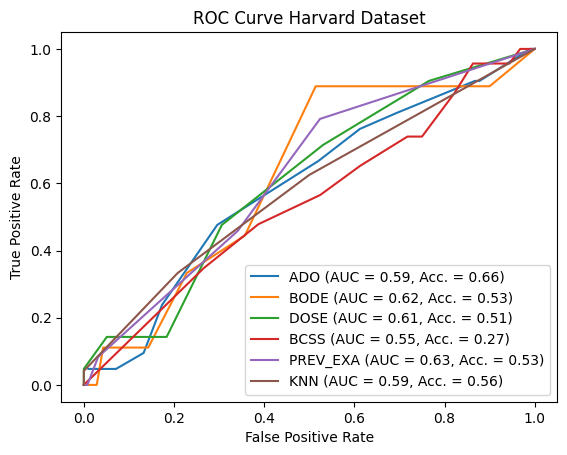

In [16]:
# fit logistic regression model to ADO score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_auc_score
from sklearn.metrics import roc_curve

ado_target = ado['exacerbation']
ado_train = ado['ADO']
bode_target = bode['exacerbation']
bode_train = bode['BODE']
dose_train = dose['DOSE']
dose_target = dose['exacerbation']
bcss_train = bcss['BCSS']
bcss_target = bcss['exacerbation']
prev_exa_train = harvard['prev_exacerbations']
prev_exa_target = harvard['exacerbation']

def calculate_tpr_fpr(data, labels):
    # calculate the cutoff points based on the highest value in the data
    cutoffs = np.linspace(0, np.max([ado_train.max(), bode_train.max(), dose_train.max(), bcss_train.max(), prev_exa_train.max()]), 100)
    # create empty lists for true positive rate and false positive rate
    tpr_list, fpr_list = [], []
    # for every cut off point
    for cutoff in cutoffs:
        # make a prediction based on the cut off point
        prediction = (data >= cutoff)
        # calculate the true positive rate
        tpr = np.sum((prediction == 1) & (labels == 1)) / np.sum(labels == 1)
        # calculate the false positive rate
        fpr = np.sum((prediction == 1) & (labels == 0)) / np.sum(labels == 0)
        # add the true positive rate to the list
        tpr_list.append(tpr)
        # add the false positive rate to the list
        fpr_list.append(fpr)
    best_cutoff = cutoffs[np.argmax(np.array(tpr_list) - np.array(fpr_list))]
    prediction = (data >= best_cutoff)
    best_accuracy = accuracy_score(labels, prediction)
    return tpr_list, fpr_list, best_accuracy

ado_tpr, ado_fpr, ado_accuracy = calculate_tpr_fpr(ado_train, ado_target)
bode_tpr, bode_fpr, bode_accuracy  = calculate_tpr_fpr(bode_train, bode_target)
dose_tpr, dose_fpr, dose_accuracy  = calculate_tpr_fpr(dose_train, dose_target)
bcss_tpr, bcss_fpr, bcss_accuracy  = calculate_tpr_fpr(bcss_train, bcss_target)
prev_exa_tpr, prev_exa_fpr, prev_exa_accuracy  = calculate_tpr_fpr(prev_exa_train, prev_exa_target)

# plot roc from loaded sklearn model
custom_fpr, custom_tpr, _ = roc_curve(harvard_preprocessed['target'], clf.predict_proba(harvard_preprocessed.drop('target', axis=1))[:,1])
custom_accuracy = accuracy_score(harvard_preprocessed['target'], clf.predict(harvard_preprocessed.drop('target', axis=1)))




# plot the ROC curve
plt.plot(ado_fpr, ado_tpr)
plt.plot(bode_fpr, bode_tpr)
plt.plot(dose_fpr, dose_tpr)
plt.plot(bcss_fpr, bcss_tpr)
plt.plot(prev_exa_fpr, prev_exa_tpr)
plt.plot(custom_fpr, custom_tpr)

# plot the best cutoff point
# plt.plot(ado_fpr[np.argmax(np.array(ado_tpr) - np.array(ado_fpr))], ado_tpr[np.argmax(np.array(ado_tpr) - np.array(ado_fpr))], 'ro')
# plt.plot(bode_fpr[np.argmax(np.array(bode_tpr) - np.array(bode_fpr))], bode_tpr[np.argmax(np.array(bode_tpr) - np.array(bode_fpr))], 'ro')
# plt.plot(dose_fpr[np.argmax(np.array(dose_tpr) - np.array(dose_fpr))], dose_tpr[np.argmax(np.array(dose_tpr) - np.array(dose_fpr))], 'ro')
# plt.plot(bcss_fpr[np.argmax(np.array(bcss_tpr) - np.array(bcss_fpr))], bcss_tpr[np.argmax(np.array(bcss_tpr) - np.array(bcss_fpr))], 'ro')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# add auc and accuracy in the legend make the last one fat
plt.legend(['ADO (AUC = %.2f, Acc. = %.2f)' % (auc(ado_fpr, ado_tpr), ado_accuracy),
            'BODE (AUC = %.2f, Acc. = %.2f)' % (auc(bode_fpr, bode_tpr), bode_accuracy), 
            'DOSE (AUC = %.2f, Acc. = %.2f)' % (auc(dose_fpr, dose_tpr), dose_accuracy),
            'BCSS (AUC = %.2f, Acc. = %.2f)' % (auc(bcss_fpr, bcss_tpr), bcss_accuracy),
            'PREV_EXA (AUC = %.2f, Acc. = %.2f)' % (auc(prev_exa_fpr, prev_exa_tpr), prev_exa_accuracy),
            'KNN (AUC = %.2f, Acc. = %.2f)' % (auc(custom_fpr, custom_tpr), custom_accuracy)
            ])
plt.title('ROC Curve Harvard Dataset')
# save as svg file
plt.savefig('plots/benchmarking_harvard.svg')
plt.show()

# Triage

## ADO

## DOSE